In [1]:
import matplotlib.pyplot as plt
from scraper import Line

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')

In [2]:
pixel_MSE_mario= Line(
    run_names=[
        "tough-firefly-1225",
        "resilient-grass-1224",
        "true-shadow-738",
        "noble-frost-735",
        "gentle-oath-733",
    ],
    x_quantity="tcount",
    y_quantity="eprew",
    color="#338B4E",
    project="burda_pathak_fork"
)

pixel_AMA_mario = Line(
    run_names=[
        "worthy-energy-801",
        "glad-cosmos-799",
        "dazzling-wind-797",
        "noble-water-795",
        "proud-glitter-793",
    ],
    x_quantity="tcount",
    y_quantity="eprew",
    color="#95275F",
    project="burda_pathak_fork"
)

idf_mario = Line(
    run_names=[
        "worldly-flower-600",
        "lucky-violet-594",
        "absurd-bush-588",
        "absurd-butterfly-573",
        "dulcet-fog-568",
    ],
    x_quantity="tcount",
    y_quantity="eprew",
    color="#EDB732",
    project="burda_pathak_fork"
)

In [3]:
ensemble_mario = Line(
    run_names=[
        "vague-river-1893",
        "devout-snowflake-1891",
        "comic-valley-1889",
        "pleasant-smoke-1874",
        "jolly-energy-1873",
    ],
    x_quantity="tcount",
    y_quantity="eprew",
    color="#C565C7",
    project="burda_pathak_fork"
)

In [4]:
import wandb
import math
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np


class Line:
    def __init__(
        self,
        run_names,
        x_quantity,
        y_quantity,
        points_to_plot=200,
        entity="self-supervisor",
        project="minigrid",
        color="blue",
    ):
        self.points_to_plot = points_to_plot
        self.run_names = run_names
        self.api = wandb.Api()
        self.runs = self.api.runs(entity + "/" + project)
        self.x_quantity = x_quantity
        self.y_quantity = y_quantity
        self.runs = self.grab_runs_based_on_names()
        self.process_run_batch()
        self.color = color

    def process_run_batch(self):
        self.filter_out_nans()
        min_x, max_x = self.get_min_x_max_x()
        x_points = self.sample_x_points(min_x, max_x)
        self.runs = self.make_filtered_runs_have_same_points(x_points)
        mean, std_error = self.compute_mean_and_std_error()
        self.x_points = x_points
        self.mean = mean
        self.std_error = std_error

    def grab_runs_based_on_names(self):
        filtered_runs = []
        for a_run in self.runs:
            if a_run.name in self.run_names:
                history = a_run.history(samples=5 * self.points_to_plot)
                x = history[self.x_quantity].values.tolist()
                y = history[self.y_quantity].values.tolist()
                filtered_runs.append([x, y])
        return filtered_runs

    def filter_out_nans(self):
        all_filtered_runs = []
        for a_run_xy in self.runs:
            run_without_nan_x = []
            run_without_nan_y = []
            nan = False
            for index, possible_nan in enumerate(a_run_xy[1]):
                if type(possible_nan) != str:
                    run_without_nan_x.append(a_run_xy[0][index])
                    run_without_nan_y.append(a_run_xy[1][index])
            all_filtered_runs.append([run_without_nan_x, run_without_nan_y])
        self.runs = all_filtered_runs

    def compute_line_equation(self, x1, y1, x2, y2):
        m = (y2 - y1) / (x2 - x1)
        c = y2 - m * x2
        return m, c

    def sample_x_points(self, min_x, max_x, number_of_points=200):
        interval = (max_x - min_x) / number_of_points
        x_points = [i * interval for i in range(number_of_points)]
        return x_points

    def make_filtered_runs_have_same_points(self, x_points):
        same_point_runs = []
        for a_run in self.runs:
            y_points = []
            for a_x in x_points:
                for index, x_value in enumerate(a_run[0]):
                    if x_value >= a_x:
                        x1 = a_run[0][index - 1]
                        y1 = a_run[1][index - 1]
                        x2 = a_run[0][index]
                        y2 = a_run[1][index]
                        m, c = self.compute_line_equation(x1, y1, x2, y2)
                        y_value = a_x * m + c
                        y_points.append(y_value)
                        break
            assert len(y_points) == len(x_points)
            same_point_runs.append([x_points, y_points])
        return same_point_runs

    def compute_mean_and_std_error(self):
        mean_list = []
        std_error_list = []
        for index, a_x_point in enumerate(self.runs[0][0]):
            points = []
            for a_run in self.runs:
                points.append(a_run[1][index])
            points = np.array(points)
            mean_list.append(np.mean(points))
            std_error_list.append(stats.sem(points))
        return mean_list, std_error_list

    def get_min_x_max_x(self):
        min_x = max([a_run[0][0] for a_run in self.runs])
        max_x = min([a_run[0][-1] for a_run in self.runs])
        return min_x, max_x

    def plot_line(self, color=None, alpha=None, label=None):
        if color == None:
            color = self.color
        if alpha == None:
            alpha = 0.2
        plt.plot(self.x_points, self.mean, color=color, label=label)
        plt.fill_between(
            self.x_points,
            np.array(self.mean) - np.array(self.std_error),
            np.array(self.mean) + np.array(self.std_error),
            alpha=alpha,
            color=color,
        )
        

RND_mario = Line(
    run_names=[
        "comfy-flower-1900",
        "comic-night-1898",
        "winter-flower-1895",
        "deep-dragon-1890",
        "logical-puddle-1871",
    ],
    x_quantity="tcount",
    y_quantity="eprew",
    color="#C565C7",
    project="burda_pathak_fork"
)

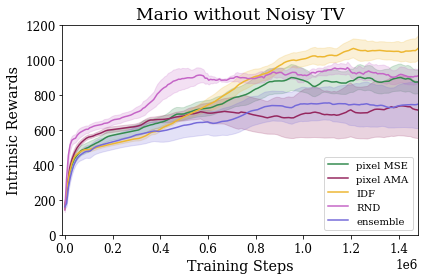

In [9]:
pixel_MSE_mario.plot_line(label="pixel MSE")
pixel_AMA_mario.plot_line(label="pixel AMA")
idf_mario.plot_line(label="IDF")
RND_mario.plot_line(label="RND")
ensemble_mario.plot_line(label="ensemble", color="#756AD9")

# make graph pretty
plt.xlabel("Training Steps", fontsize="x-large")
plt.ylabel("Intrinsic Rewards", fontsize="x-large")
plt.xlim(-1e4,1.48e6)
plt.ylim(0,1200)
plt.title("Mario without Noisy TV", fontsize="xx-large")
plt.tight_layout()
plt.savefig("MarioWithoutNoisyTV.png", dpi=1200)
plt.legend()
plt.show()